In [ ]:
#установка библиотеки retentioneering
#!pip3 install --upgrade git+https://github.com/retentioneering/retentioneering-tools.git@dev2
!pip install retentioneering==2.0.3.2

     |████████████████████████████████| 817 kB 31.8 MB/s 
     |████████████████████████████████| 1.3 MB 72.4 MB/s 
     |████████████████████████████████| 3.4 MB 49.7 MB/s 
     |████████████████████████████████| 23.2 MB 1.3 MB/s 
     |████████████████████████████████| 9.8 MB 70.1 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
     |████████████████████████████████| 25.3 MB 87 kB/s 
     |████████████████████████████████| 1.1 MB 46.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=808a873dd03c4220699f43835adb2e81722d2c3df4803777ae3c59a6d9a316fb
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=abf08b9435a1a41cda8a1b10e28fd206f787f63555794a0e168023a2d3f2e835
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Success

In [ ]:
import pandas as pd
import io
import retentioneering
import numpy as np
import datetime
from copy import deepcopy
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

In [ ]:
retentioneering.config.update({
    'event_col':'event',
    'event_time_col':'timestamp',
    'user_col': 'client_id'
})

Код построения и визуализации воронок взят из https://medium.com/multiplyai/user-conversion-funnel-9d957ce3e80c

In [ ]:
def create_funnel_df(df, steps, from_date=None, to_date=None, step_interval=0, closed=True):
    """
    Function used to create a dataframe that can be passed to functions for generating funnel plots.
    """
    # filter df for only events in the steps list
    df = df[['client_id', 'mapped_event', 'timestamp']]
    df = df[df['mapped_event'].isin(steps)]

    values = []
    # for the rest steps, create a df and filter only for that step
    for i, step in enumerate(steps):
        if i == 0:
            dfs = {}

            dfs[step] = df[df['mapped_event'] == step] \
                .sort_values(['client_id', 'timestamp'], ascending=True) \
                .drop_duplicates(subset=['client_id', 'mapped_event'], keep='first')

            # filter df of 1st step according to dates
            if from_date:
                dfs[step] = dfs[step][(dfs[step]['timestamp'] >= from_date)]

            if to_date:
                dfs[step] = dfs[step][(dfs[step]['timestamp'] <= to_date)]

        else:
            dfs[step] = df[df['mapped_event'] == step]
            if not closed:
                dfs[step].drop_duplicates(subset=['client_id'], inplace=True)
            else:
                # outer join with previous step
                merged = pd.merge(dfs[steps[i - 1]], dfs[step], on='client_id', how='outer')

                # keep only rows for which the distinct_ids appear in the previous step
                valid_ids = dfs[steps[i - 1]]['client_id'].unique()
                merged = merged[merged['client_id'].isin(valid_ids)]

                # keep only events that happened after previous step and sort by time
                merged = merged[merged['timestamp_y'] >=
                                (merged['timestamp_x'] + pd.Timedelta(step_interval))].sort_values('timestamp_y', ascending=True)

                # take the minimum time of the valid ones for each user
                merged = merged.drop_duplicates(subset=['client_id', 'mapped_event_x', 'mapped_event_y'], keep='first')

                # keep only the necessary columns and rename them to match the original structure
                merged = merged[['client_id', 'mapped_event_y', 'timestamp_y']].rename({'mapped_event_y': 'mapped_event',
                                                                             'timestamp_y': 'timestamp'}, axis=1)

                # include the df in the df dictionary so that it can be joined to the next step's df
                dfs[step] = merged

        # append number of users to the "values" list
        values.append(len(dfs[step]))

    # create dataframe
    funnel_df = pd.DataFrame({'step': steps, 'val': values})
    # calculate percentage conversion for each step
    funnel_df['pct'] = (100 - 100 * abs(funnel_df['val'].pct_change()).fillna(0)).astype(int)
    # shift val by one to plot faded bars of previous step in background
    funnel_df['val-1'] = funnel_df['val'].shift(1)
    # calculate percentage conversion between each step and the first step in the funnel
    funnel_df['pct_from_first'] = (funnel_df['val'] / funnel_df['val'].loc[0] * 100).fillna(0).astype(int)

    return funnel_df


def group_funnel_dfs(events, steps, col, closed=True):
    """
    Function used to create a dict of funnel dataframes used to generate a stacked funnel plot.
    """
    dict_ = {}
    
    # get the distinct_ids for each property that we are grouping by
    ids = dict(events.groupby([col])['client_id'].apply(set))

    for entry in events[col].dropna().unique():
        ids_list = ids[entry]
        df = events[events['client_id'].isin(ids_list)].copy()
        if len(df[df['mapped_event'] == steps[0]]) > 0:
            dict_[entry] = create_funnel_df(df, steps, closed=closed)

    return dict_


def plot_stacked_funnel(events, steps, col=None, from_date=None, to_date=None, step_interval=0, closed=True):
    """
    Function used for producing a (stacked) funnel plot.
    """
    # create list to append each trace to
    # this will be passed to "go.Figure" at the end
    data = []

    # if col is provided, create a funnel_df for each entry in the "col"
    if col:
        # generate dict of funnel dataframes
        dict_ = group_funnel_dfs(events, steps, col, closed=closed)
        title = 'Funnel plot per {}'.format(col)
    else:
        funnel_df = create_funnel_df(events, steps, from_date=from_date, to_date=to_date, step_interval=step_interval, closed=closed)
        dict_ = {'Total': funnel_df}
        title = 'Funnel plot'

    for t in dict_.keys():
        trace = go.Funnel(
            name=t,
            y=dict_[t].step.values,
            x=dict_[t].val.values,
            textinfo="value+percent previous"
        )
        data.append(trace)

    layout = go.Layout(margin={"l": 180, "r": 0, "t": 30, "b": 0, "pad": 0},
                       funnelmode="stack",
                       showlegend=True,
                       hovermode='closest',
                       title='Funnel plot per {}'.format(col),
                       legend=dict(orientation="v",
                                   bgcolor='#E2E2E2',
                                   xanchor='left',
                                   font=dict(
                                       size=12)
                                   )
                       )

    return go.Figure(data, layout)

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving 4.11_homework_dataset.csv to 4.11_homework_dataset (1).csv


In [ ]:
#data = pd.read_csv(io.StringIO(uploaded['4.8_practice_dataset.csv'].decode('utf-8')),sep=',')
data = pd.read_csv('4.11_homework_dataset.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values('timestamp')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69841 entries, 5364 to 229
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   channel    69841 non-null  object        
 1   client_id  69841 non-null  int64         
 2   event      69841 non-null  object        
 3   platform   69841 non-null  object        
 4   region     69841 non-null  object        
 5   timestamp  69841 non-null  datetime64[ns]
 6   user_type  69841 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 4.3+ MB


Посмотрим на наши данные

In [ ]:
data.head()

,channel,client_id,event,platform,region,timestamp,user_type
5364,fb,924523693,main,PC,spb,2019-11-02 17:16:00.881390,user__search
56879,vk,810735621,catalog/motobikes,android,moscow,2019-11-02 17:20:35.095998,user__search
21745,fb,168343349,catalog/motobikes,PC,moscow,2019-11-02 17:26:42.287648,user__search
21746,fb,168343349,"catalog/motobikes/Road Glide Limited 114, Harl...",PC,moscow,2019-11-02 17:26:42.414465,user__search
21747,fb,168343349,request_call,PC,moscow,2019-11-02 17:27:32.440646,user__search


Степ матрица показывает для каждого шага распределение по событиям произошедшим на этом шаге

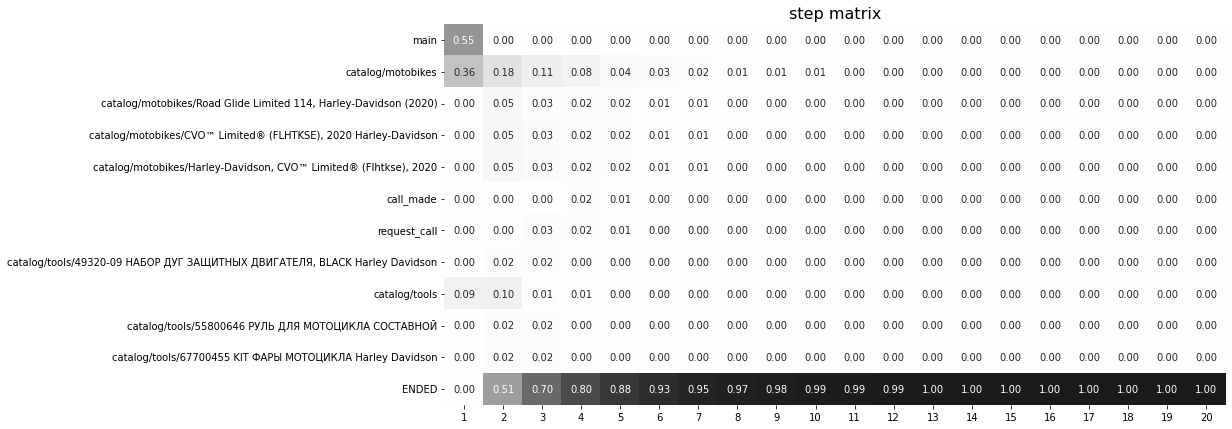

In [ ]:
desc_table = data.rete.step_matrix(max_steps=20)

In [ ]:
data['event'].value_counts()

catalog/motobikes                                                             26228
main                                                                          16515
catalog/tools                                                                  6296
catalog/motobikes/CVO™ Limited® (FLHTKSE), 2020 Harley-Davidson                4665
catalog/motobikes/Harley-Davidson, CVO™ Limited® (Flhtkse), 2020               4585
catalog/motobikes/Road Glide Limited 114, Harley-Davidson (2020)               4582
request_call                                                                   1922
call_made                                                                      1448
catalog/tools/49320-09 НАБОР ДУГ ЗАЩИТНЫХ ДВИГАТЕЛЯ, BLACK Harley Davidson     1217
catalog/tools/55800646 РУЛЬ ДЛЯ МОТОЦИКЛА СОСТАВНОЙ                            1215
catalog/tools/67700455 KIT ФАРЫ МОТОЦИКЛА Harley Davidson                      1168
Name: event, dtype: int64

Будем анализировать не все события, а только наиболее значимые

In [ ]:
def map_event(event):
    if event in ('catalog/motobikes', 'main', 'catalog/tools', 'request_call', 'call_made'):
        return event
    elif event in ('catalog/motobikes/CVO™ Limited® (FLHTKSE), 2020 Harley-Davidson', 'catalog/motobikes/Harley-Davidson, CVO™ Limited® (Flhtkse), 2020', 'catalog/motobikes/Road Glide Limited 114, Harley-Davidson (2020)'):
        return 'catalog/motobikes'
    elif event in ('catalog/tools/49320-09 НАБОР ДУГ ЗАЩИТНЫХ ДВИГАТЕЛЯ, BLACK Harley Davidson', 'catalog/tools/55800646 РУЛЬ ДЛЯ МОТОЦИКЛА СОСТАВНОЙ', 'catalog/tools/67700455 KIT ФАРЫ МОТОЦИКЛА Harley Davidson'):
        return 'catalog/tools'
    else:
        return None

In [ ]:
data['mapped_event'] = list(map(map_event, data['event']))

In [ ]:
data.dropna(subset=['mapped_event'], inplace=True)

Это список выделенных событий, какие то из сырых событий мы склеили в одно, какие то выбросили

In [ ]:
stages = ['main',
          'catalog/motobikes',
          'catalog/tools',
          'request_call', 
          'call_made']

### Для анализа конверсии в определенные события на сайте используем воронку

Бывают открытые и закрытые воронки

#### 1) Закрытая воронка

Показывает для каждого этапа, сколько пользователей до него дошли, пройдя все предыдущие: абсолютное значение пользователей и конверсию из предыдущего этапа

In [ ]:
plot_stacked_funnel(data, stages, col='channel')

#### 2) Открытая воронка

Отличие от закртой воронки -- пользователь будет учтен на очередном этапе, независимо от прохождения им предыдущих. Из за этого количество пользователей не обязано убывать по мере прохождения воронки

In [ ]:
plot_stacked_funnel(data, stages, col='channel', closed=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Видим, что открытая воронка совпадает с закрытой в данном случае, везде кроме последнего этапа. Событие passed в данном контексте -- любое событие в приложении после онбординга. Очевидно что так происходит просто потому, что онбординг показвается не всем пользователям (например только тем кто его раньше не проходил)

На закртытой же воронке видим, что с мобильных устройств конверсия сильно меньше, причем больше всего мы теряем на последнем этапе. Возможно неудобно реализован онбординг в приложении или технические баги